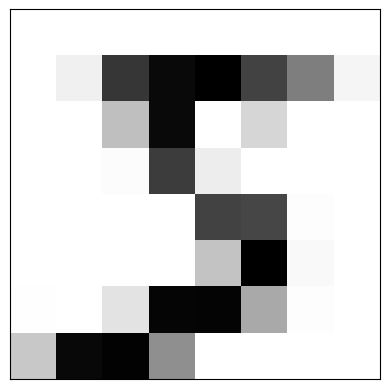

In [1]:
import MNIST_database as mnist
from matplotlib import pyplot as plt


#Choose the final size of your image dataset
size_final = 8

# data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=5, flat=True)
data_zoom = mnist.MNISTData(size_initial=20, size_final=8, color_depth=8, flat=True)

# x_train= data_zoom.x_train
# y_train= data_zoom.y_train
# x_test= data_zoom.x_test
# y_test= data_zoom.y_test

ax = plt.subplot(1, 1 , 1)
plt.imshow(data_zoom.x_train[0].reshape(size_final,size_final), cmap='gray_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [4]:
BIT_WIDTH = 8
EPOCHS = 40
Q_EPOCHS = 80
BATCH_SIZE = 32
MODEL_NAME = 'model'

# def model

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from callbacks import all_callbacks
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow_model_optimization as tfmot
import os 
# import MNIST_database as mnist
from matplotlib import pyplot as plt


#Choose the final size of your image dataset
size_final = 8
# data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=8, flat=True)

class QAutoencoder:
    def __init__(self, data: mnist.MNISTData, bit_width=8, EPOCHS=1, Q_EPOCHS=1, model_name='model'):

        self.x_train = data.x_train
        self.y_train = data.y_train
        self.x_test = data.x_test
        self.y_test = data.y_test
        self.input_min = np.min(data.x_train)
        self.input_max = np.max(data.x_train)
        self.input_shape = (data.x_train.shape[-1],)
        self.BIT_WIDTH = bit_width
        self.EPOCHS = EPOCHS
        self.Q_EPOCHS = Q_EPOCHS
        self.MODEL_NAME = model_name
        self.model = self.autoencoder_model_gen()
        self.history = None
        self.loss = None
        self.float_model_predictions = None

        self.q_aware_model = None
        self.quantized_tflite_model = None
        self.interpreter = None
        self.input_details = None
        self.output_details = None
        self.quantized_model_predictions = None

    def autoencoder_model_gen(self):

        # Encoder
        encoder_input = Input(shape=self.input_shape)
        encoder_l1 = Dense(64, activation='relu')(encoder_input)
        encoder_l2 = Dense(32, activation='relu')(encoder_l1)
        encoder_l3 = Dense(16, activation='relu')(encoder_l2)
        encoder_output = Dense(2, activation='relu')(encoder_l3)

        # Decoder
        decoder_l1 = Dense(16, activation='relu')(encoder_output)
        decoder_l2 = Dense(32, activation='relu')(decoder_l1)
        decoder_l3 = Dense(32, activation='relu')(decoder_l2)
        # decoder_output = Dense(y_train.shape[-1], activation='sigmoid')(decoder_l3) # classifier
        # decoder_output = Dense(
        #     self.x_train.shape[-1], activation='sigmoid')(decoder_l3)  # autoencoder
        decoder_output = Dense(self.x_train.shape[-1], activation='linear')(decoder_l3)

        # Model
        model = Model(inputs=encoder_input, outputs=decoder_output)
        # refactor the code above to use the functional AP

        model.compile(optimizer='adam', loss='mse')
        # model.compile(optimizer='adam', loss='binary_crossentropy') # classifier
        return model

    def fit_data(self, batch_size=256, epochs=Q_EPOCHS):
        """Write the fit function for the autoencoder. 
        Storing the fit history in self.history to be able to plot the fitting scores."""

        callbacks = all_callbacks(stop_patience=1000,
                                  lr_factor=0.5,
                                  lr_patience=10,
                                  lr_epsilon=0.000001,
                                  # min_delta=0.000001,
                                  lr_cooldown=2,
                                  lr_minimum=0.0000001,
                                  outputDir=f'model/QAE_model{self.BIT_WIDTH}bits/callbacks')
        # callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())

        self.history = self.model.fit(self.x_train, self.x_train,
                                      validation_data=(
                                          self.x_test, self.x_test),
                                      batch_size=batch_size, epochs=epochs,
                                      shuffle=True, callbacks=callbacks.callbacks)
        # self.model = strip_pruning(self.model)
        self.loss = self.model.evaluate(self.x_test, self.x_test, verbose=0)
        self.model.save(
            # f'model/QAE_model{self.BIT_WIDTH}bits/KERAS_check_best_model.h5')
            f'model/model_{self.loss}loss/KERAS_check_best_model.model')
        self.history = self.history.history
        self.convert_to_Q_aware()

    def plot_float_model(self, n=6):
        """Plot the float model"""
        
        plt.figure(figsize=(10, 3))
        self.float_model_predictions = self.model.predict(self.x_test)
        self._extracted_from_plot_quantized_model_8(
            n,
            self.float_model_predictions,
            './images/QAE/reconstructed images {model_name}.png',
        )

    # def representative_dataset(self):
    #     for data in self.x_train:
    #         # yield [np.array([data], dtype=np.float32)]
    #         yield [np.array([data * (2 ** (self.BIT_WIDTH - 1))], dtype=np.float32)]

    def representative_dataset(self):
        for data in self.x_train:
            # Scale the data using min and max values
            scaled_data = (data - self.input_min) / (self.input_max - self.input_min) * (2 ** (self.BIT_WIDTH - 1))
            yield [np.array([scaled_data], dtype=np.float32)]

    def convert_to_Q_aware(self):

        # converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # converter.representative_dataset = self.representative_dataset
        # converter.target_spec.supported_ops = [
        #     tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        # converter.inference_input_type = tf.int8
        # converter.inference_output_type = tf.int8

        # self.q_aware_model = converter.convert()

        # # Load the quantized model
        # self.interpreter = tf.lite.Interpreter(
        #     model_path='quantized_model.tflite')
        # self.interpreter.allocate_tensors()
        # ------------
        quantize_model = tfmot.quantization.keras.quantize_model
        self.q_aware_model = quantize_model(self.model)
        self.q_aware_model.compile(optimizer='adam', loss='mse')
        self.fit_data_Q_aware()
        # loss = self.q_aware_model.evaluate(self.x_test, self.x_test, verbose=0)

        # # Save the quantized model
        # with open(f'quantized_model.tflite', 'wb') as f:
        #     f.write(self.q_aware_model)

        self.convert_to_tflite()

    def fit_data_Q_aware(self, batch_size=256, epochs=Q_EPOCHS):
        """Write the fit function for the autoencoder. 
        Storing the fit history in self.history to be able to plot the fitting scores."""

        callbacks = all_callbacks(stop_patience=1000,
                                  lr_factor=0.5,
                                  lr_patience=10,
                                  lr_epsilon=0.000001,
                                  # min_delta=0.000001,
                                  lr_cooldown=2,
                                  lr_minimum=0.0000001,
                                  outputDir=f'model/QAE_model{self.BIT_WIDTH}bits/callbacks')
        # callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())

        self.history_Q_aware = self.q_aware_model.fit(self.x_train, self.x_train,
                                      validation_data=(
                                          self.x_test, self.x_test),
                                      batch_size=batch_size, epochs=epochs,
                                      shuffle=True, callbacks=callbacks.callbacks)
        # self.model = strip_pruning(self.model)
        self.q_aware_model.save(
            # f'model/QAE_model{self.BIT_WIDTH}bits/KERAS_check_best_model.h5')
            f'model/QAE_model{self.BIT_WIDTH}bits/KERAS_check_best_model.model')
        self.history_Q_aware = self.history_Q_aware.history
        self.loss = self.q_aware_model.evaluate(self.x_test, self.x_test, verbose=0)
        # self.convert_to_Q_aware()    

    def convert_to_tflite(self):
        converter = tf.lite.TFLiteConverter.from_keras_model(self.q_aware_model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = self.representative_dataset
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8

        self.quantized_tflite_model = converter.convert()

        # Save the TensorFlow Lite model
        with open("model_obj_tflite_model.tflite", "wb") as file:
            file.write(self.quantized_tflite_model)

        # Load the quantized model
        # self.interpreter = tf.lite.Interpreter(model_path='quantized_model.tflite')
        self.interpreter = tf.lite.Interpreter(model_content=self.quantized_tflite_model)

        self.interpreter.allocate_tensors()

        # Get input and output details
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.quantized_predictions()



    def quantized_predictions(self, n=6):
        quantized_model_predictions = []

        for i in range(n):
            # Prepare input data
            # input_data = np.array(
            #     [self.x_test[i]*(2**(self.BIT_WIDTH-1))], dtype=np.int8)
            input_data = np.array([(self.x_test[i] - self.input_min) / (self.input_max - self.input_min) * (2 ** (self.BIT_WIDTH - 1))], dtype=np.int8)  

            self.interpreter.set_tensor(
                self.input_details[0]['index'], input_data)
            print(f"input_data: {input_data}")
            # Run inference
            self.interpreter.invoke()

            # Get output
            output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
            output_data = self.interpreter.get_tensor(
                # self.output_details[0]['index']) / (2 ** (self.BIT_WIDTH - 1))
                self.output_details[0]['index'])
            # output_data = output_data * (self.input_max - self.input_min) / (2 ** (self.BIT_WIDTH - 1)) + self.input_min
            # output_data = output_data / (2 ** (self.BIT_WIDTH - 1))
            print(f"output_data: {output_data}")
            quantized_model_predictions.append(output_data)
        
        self.quantized_model_predictions = quantized_model_predictions
        # self.compute_mse()

    def plot_quantized_model(self, n=6):

        
        plt.figure(figsize=(10, 3))
        self._extracted_from_plot_quantized_model_8(
            n,
            self.quantized_model_predictions,
            './images/QAE/reconstructed images{model_name}.png',
        )

    # TODO Rename this here and in `plot_float_model` and `plot_quantized_model`
    def _extracted_from_plot_quantized_model_8(self, n, quantized_model_predictions, imgs_path):
        img_size = int(np.sqrt(self.input_shape[0]))
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            self.plot_imgs(
                self.x_test, i, img_size, ax
            )
            ax = plt.subplot(2, n, i + n + 1)
            self.plot_imgs(
                quantized_model_predictions, i, img_size, ax
            )
        if not os.path.exists(imgs_path):
            os.makedirs(imgs_path)
        plt.savefig(imgs_path.format(model_name=" complete"))
        plt.show()

    # TODO Rename this here and in `plot_float_model` and `plot_quantized_model`
    def plot_imgs(self, arg0, i, img_size, ax):
        plt.imshow(arg0[i].reshape(img_size, img_size), cmap='gray_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    def compute_mse(self):
        mse = mean_squared_error(self.float_model_predictions, self.quantized_model_predictions)
        print(f'Mean Squared Error between floating point and quantized model predictions: {mse}')
        self.mse = mse

model_obj = QAutoencoder(data_zoom, bit_width=BIT_WIDTH, model_name=MODEL_NAME, EPOCHS=EPOCHS, Q_EPOCHS=Q_EPOCHS)
# model.fit(x_train, y_train, epochs=10, batch_size=32) # classifier
model_obj.model.summary()
# model.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE) #autoencoder


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
 dense_4 (Dense)             (None, 16)                48        
                                                                 
 dense_5 (Dense)             (None, 32)                544   

# fit

In [6]:
model_obj.fit_data(epochs=EPOCHS)  # batch_size=BATCH_SIZE, epochs=EPOCHS)


Epoch 1/40
226/235 [===========================>..] - ETA: 0s - loss: 0.1089
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00001: val_loss improved from inf to 0.09351, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets

Epoch 00001: val_loss improved from inf to 0.09351, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets

Epoch 00001: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 8s 25ms/step - loss: 0.1083 - val_loss: 0.0935 - lr: 0.0010
Epoch 2/40
230/235 [============================>.] - ETA: 0s - loss: 0

INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00001: val_loss improved from inf to 0.06278, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00001: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 16s 58ms/step - loss: 0.0648 - val_loss: 0.0628 - lr: 0.0010
Epoch 2/40
226/235 [===========================>..] - ETA: 0s - loss: 0.0627
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00002: val_loss improved from 0.06278 to 0.06268, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00002: val_loss improved from 0.06278 to 0.06268, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00002: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00002: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 13s 54ms/step - loss: 0.0628 - val_loss: 0.0627 - lr: 0.0010
Epoch 3/40
229/235 [============================>.] - ETA: 0s - loss: 0.0622
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00003: val_loss improved from 0.06268 to 0.06226, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00003: val_loss improved from 0.06268 to 0.06226, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00003: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00003: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 11s 45ms/step - loss: 0.0623 - val_loss: 0.0623 - lr: 0.0010
Epoch 4/40
230/235 [============================>.] - ETA: 0s - loss: 0.0618
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00004: val_loss did not improve from 0.06226

Epoch 00004: val_loss did not improve from 0.06226

Epoch 00004: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00004: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 24ms/step - loss: 0.0618 - val_loss: 0.0624 - lr: 0.0010
Epoch 5/40
232/235 [============================>.] - ETA: 0s - loss: 0.0617
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00005: val_loss improved from 0.06226 to 0.06174, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00005: val_loss improved from 0.06226 to 0.06174, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00005: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00005: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 10s 43ms/step - loss: 0.0617 - val_loss: 0.0617 - lr: 0.0010
Epoch 6/40
233/235 [============================>.] - ETA: 0s - loss: 0.0616
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00006: val_loss did not improve from 0.06174

Epoch 00006: val_loss did not improve from 0.06174

Epoch 00006: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00006: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 27ms/step - loss: 0.0616 - val_loss: 0.0624 - lr: 0.0010
Epoch 7/40
228/235 [============================>.] - ETA: 0s - loss: 0.0616
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00007: val_loss did not improve from 0.06174

Epoch 00007: val_loss did not improve from 0.06174

Epoch 00007: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00007: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 27ms/step - loss: 0.0616 - val_loss: 0.0624 - lr: 0.0010
Epoch 8/40
233/235 [============================>.] - ETA: 0s - loss: 0.0611
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00008: val_loss improved from 0.06174 to 0.06149, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00008: val_loss improved from 0.06174 to 0.06149, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00008: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00008: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 14s 59ms/step - loss: 0.0612 - val_loss: 0.0615 - lr: 0.0010
Epoch 9/40
231/235 [============================>.] - ETA: 0s - loss: 0.0612
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00009: val_loss did not improve from 0.06149

Epoch 00009: val_loss did not improve from 0.06149

Epoch 00009: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00009: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 26ms/step - loss: 0.0612 - val_loss: 0.0617 - lr: 0.0010
Epoch 10/40
233/235 [============================>.] - ETA: 0s - loss: 0.0616
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00010: val_loss did not improve from 0.06149

Epoch 00010: val_loss did not improve from 0.06149

Epoch 00010: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00010: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

Epoch 00010: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_epoch10.h5

***callbacks end***

235/235 [==============================] - 6s 26ms/step - loss: 0.0616 - val_loss: 0.0617 - lr: 0.0010
Epoch 11/40
231/235 [============================>.] - ETA: 0s - loss: 0.0612
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00011: val_loss improved from 0.06149 to 0.06126, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00011: val_loss improved from 0.06149 to 0.06126, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00011: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00011: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 10s 43ms/step - loss: 0.0612 - val_loss: 0.0613 - lr: 0.0010
Epoch 12/40
229/235 [============================>.] - ETA: 0s - loss: 0.0613
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00012: val_loss did not improve from 0.06126

Epoch 00012: val_loss did not improve from 0.06126

Epoch 00012: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00012: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 27ms/step - loss: 0.0612 - val_loss: 0.0615 - lr: 0.0010
Epoch 13/40
232/235 [============================>.] - ETA: 0s - loss: 0.0612
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00013: val_loss improved from 0.06126 to 0.06114, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00013: val_loss improved from 0.06126 to 0.06114, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00013: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00013: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 12s 50ms/step - loss: 0.0611 - val_loss: 0.0611 - lr: 0.0010
Epoch 14/40
235/235 [==============================] - ETA: 0s - loss: 0.0610
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00014: val_loss did not improve from 0.06114

Epoch 00014: val_loss did not improve from 0.06114

Epoch 00014: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00014: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 24ms/step - loss: 0.0610 - val_loss: 0.0621 - lr: 0.0010
Epoch 15/40
231/235 [============================>.] - ETA: 0s - loss: 0.0609
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00015: val_loss did not improve from 0.06114

Epoch 00015: val_loss did not improve from 0.06114

Epoch 00015: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00015: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 26ms/step - loss: 0.0609 - val_loss: 0.0624 - lr: 0.0010
Epoch 16/40
226/235 [===========================>..] - ETA: 0s - loss: 0.0609
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00016: val_loss did not improve from 0.06114

Epoch 00016: val_loss did not improve from 0.06114

Epoch 00016: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00016: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 25ms/step - loss: 0.0609 - val_loss: 0.0614 - lr: 0.0010
Epoch 17/40
233/235 [============================>.] - ETA: 0s - loss: 0.0607
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00017: val_loss improved from 0.06114 to 0.06108, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00017: val_loss improved from 0.06114 to 0.06108, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00017: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00017: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 12s 50ms/step - loss: 0.0607 - val_loss: 0.0611 - lr: 0.0010
Epoch 18/40
228/235 [============================>.] - ETA: 0s - loss: 0.0607
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00018: val_loss improved from 0.06108 to 0.06074, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00018: val_loss improved from 0.06108 to 0.06074, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00018: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00018: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 14s 60ms/step - loss: 0.0606 - val_loss: 0.0607 - lr: 0.0010
Epoch 19/40
229/235 [============================>.] - ETA: 0s - loss: 0.0604
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00019: val_loss improved from 0.06074 to 0.06047, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00019: val_loss improved from 0.06074 to 0.06047, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00019: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00019: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 11s 47ms/step - loss: 0.0604 - val_loss: 0.0605 - lr: 0.0010
Epoch 20/40
227/235 [===========================>..] - ETA: 0s - loss: 0.0606
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00020: val_loss did not improve from 0.06047

Epoch 00020: val_loss did not improve from 0.06047

Epoch 00020: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00020: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

Epoch 00020: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_epoch20.h5

***callbacks end***

235/235 [==============================] - 8s 33ms/step - loss: 0.0606 - val_loss: 0.0617 - lr: 0.0010
Epoch 21/40
230/235 [============================>.] - ETA: 0s - loss: 0.0606
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00021: val_loss did not improve from 0.06047

Epoch 00021: val_loss did not improve from 0.06047

Epoch 00021: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00021: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 32ms/step - loss: 0.0606 - val_loss: 0.0610 - lr: 0.0010
Epoch 22/40
226/235 [===========================>..] - ETA: 0s - loss: 0.0604
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00022: val_loss did not improve from 0.06047

Epoch 00022: val_loss did not improve from 0.06047

Epoch 00022: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00022: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 27ms/step - loss: 0.0604 - val_loss: 0.0612 - lr: 0.0010
Epoch 23/40
228/235 [============================>.] - ETA: 0s - loss: 0.0604
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00023: val_loss did not improve from 0.06047

Epoch 00023: val_loss did not improve from 0.06047

Epoch 00023: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00023: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 27ms/step - loss: 0.0604 - val_loss: 0.0606 - lr: 0.0010
Epoch 24/40
235/235 [==============================] - ETA: 0s - loss: 0.0606
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00024: val_loss improved from 0.06047 to 0.06033, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00024: val_loss improved from 0.06047 to 0.06033, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00024: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00024: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 12s 50ms/step - loss: 0.0606 - val_loss: 0.0603 - lr: 0.0010
Epoch 25/40
230/235 [============================>.] - ETA: 0s - loss: 0.0603
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00025: val_loss did not improve from 0.06033

Epoch 00025: val_loss did not improve from 0.06033

Epoch 00025: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00025: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 28ms/step - loss: 0.0604 - val_loss: 0.0606 - lr: 0.0010
Epoch 26/40
226/235 [===========================>..] - ETA: 0s - loss: 0.0605
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00026: val_loss did not improve from 0.06033

Epoch 00026: val_loss did not improve from 0.06033

Epoch 00026: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00026: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 29ms/step - loss: 0.0605 - val_loss: 0.0605 - lr: 0.0010
Epoch 27/40
232/235 [============================>.] - ETA: 0s - loss: 0.0603
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00027: val_loss did not improve from 0.06033

Epoch 00027: val_loss did not improve from 0.06033

Epoch 00027: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00027: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 28ms/step - loss: 0.0603 - val_loss: 0.0605 - lr: 0.0010
Epoch 28/40
231/235 [============================>.] - ETA: 0s - loss: 0.0602
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00028: val_loss did not improve from 0.06033

Epoch 00028: val_loss did not improve from 0.06033

Epoch 00028: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00028: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 29ms/step - loss: 0.0602 - val_loss: 0.0606 - lr: 0.0010
Epoch 29/40
235/235 [==============================] - ETA: 0s - loss: 0.0605
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00029: val_loss did not improve from 0.06033

Epoch 00029: val_loss did not improve from 0.06033

Epoch 00029: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00029: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 28ms/step - loss: 0.0605 - val_loss: 0.0617 - lr: 0.0010
Epoch 30/40
230/235 [============================>.] - ETA: 0s - loss: 0.0602
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00030: val_loss did not improve from 0.06033

Epoch 00030: val_loss did not improve from 0.06033

Epoch 00030: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00030: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

Epoch 00030: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_epoch30.h5

***callbacks end***

235/235 [==============================] - 7s 28ms/step - loss: 0.0602 - val_loss: 0.0614 - lr: 0.0010
Epoch 31/40
234/235 [============================>.] - ETA: 0s - loss: 0.0601
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00031: val_loss did not improve from 0.06033

Epoch 00031: val_loss did not improve from 0.06033

Epoch 00031: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00031: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 31ms/step - loss: 0.0601 - val_loss: 0.0607 - lr: 0.0010
Epoch 32/40
234/235 [============================>.] - ETA: 0s - loss: 0.0601
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00032: val_loss did not improve from 0.06033

Epoch 00032: val_loss did not improve from 0.06033

Epoch 00032: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00032: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 8s 33ms/step - loss: 0.0601 - val_loss: 0.0608 - lr: 0.0010
Epoch 33/40
234/235 [============================>.] - ETA: 0s - loss: 0.0600
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00033: val_loss did not improve from 0.06033

Epoch 00033: val_loss did not improve from 0.06033

Epoch 00033: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00033: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 29ms/step - loss: 0.0600 - val_loss: 0.0607 - lr: 0.0010
Epoch 34/40
228/235 [============================>.] - ETA: 0s - loss: 0.0604
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00034: val_loss did not improve from 0.06033

Epoch 00034: val_loss did not improve from 0.06033

Epoch 00034: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00034: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

***callbacks end***

235/235 [==============================] - 7s 30ms/step - loss: 0.0603 - val_loss: 0.0606 - lr: 0.0010
Epoch 35/40
232/235 [============================>.] - ETA: 0s - loss: 0.0598
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00035: val_loss improved from 0.06033 to 0.05992, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00035: val_loss improved from 0.06033 to 0.05992, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00035: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00035: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 12s 49ms/step - loss: 0.0598 - val_loss: 0.0599 - lr: 5.0000e-04
Epoch 36/40
231/235 [============================>.] - ETA: 0s - loss: 0.0598
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00036: val_loss did not improve from 0.05992

Epoch 00036: val_loss did not improve from 0.05992

Epoch 00036: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00036: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 30ms/step - loss: 0.0599 - val_loss: 0.0602 - lr: 5.0000e-04
Epoch 37/40
228/235 [============================>.] - ETA: 0s - loss: 0.0599
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00037: val_loss did not improve from 0.05992

Epoch 00037: val_loss did not improve from 0.05992

Epoch 00037: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00037: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 27ms/step - loss: 0.0599 - val_loss: 0.0607 - lr: 5.0000e-04
Epoch 38/40
233/235 [============================>.] - ETA: 0s - loss: 0.0598
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00038: val_loss did not improve from 0.05992

Epoch 00038: val_loss did not improve from 0.05992

Epoch 00038: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00038: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 29ms/step - loss: 0.0598 - val_loss: 0.0604 - lr: 5.0000e-04
Epoch 39/40
232/235 [============================>.] - ETA: 0s - loss: 0.0597
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00039: val_loss improved from 0.05992 to 0.05976, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00039: val_loss improved from 0.05992 to 0.05976, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00039: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00039: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 15s 65ms/step - loss: 0.0597 - val_loss: 0.0598 - lr: 5.0000e-04
Epoch 40/40
233/235 [============================>.] - ETA: 0s - loss: 0.0594
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00040: val_loss did not improve from 0.05976

Epoch 00040: val_loss did not improve from 0.05976

Epoch 00040: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00040: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

Epoch 00040: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_epoch40.h5

***callbacks end***

235/235 [==============================] - 7s 32ms/step - loss: 0.0594 - val_loss: 0.0603 - lr: 5.0000e-04


INFO:tensorflow:Assets written to: model/QAE_model8bits/KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: C:\Users\luisa\AppData\Local\Temp\tmp3sapg88w\assets


INFO:tensorflow:Assets written to: C:\Users\luisa\AppData\Local\Temp\tmp3sapg88w\assets


input_data: [[   0    0    0    0    0    0    0    0    0   56   34    0    0    0
     0    0    0   24   31   89   92   71  118    0    0    0    0    0
     0   76   18    0    0    0    0    0    0  127    1    0    0    0
     0    0   92   15    0    0    0    0    0   13  102    1    0    0
     0    0    0 -128    0    0    0    0]]
output_data: [[-91 -88 -92 -81 -18  -1 -65 -90 -91 -95 -94 -44  27 -50 -88 -86 -93 -99
  -80  27 -40 -71 -98 -95 -91 -91 -23  29 -51 -39 -77 -92 -90 -82  16  -4
   17  21 -36 -87 -91 -62  15  -1 -25  26 -48 -92 -89 -70  14  50  34 -20
  -89 -94 -90 -91 -87 -90 -90 -88 -92 -93]]
input_data: [[   0    2  111  126  126    0    0    0    0   20   83    0  107    9
     0    0    0    1    0   23 -128    0    0    0    0    0    0 -128
     7    0    0    0    0    0   72   88    0    0    0    0    0    0
  -128    0    2    1    2    0    0    0  126 -128 -128   97 -128  124
     0    0    0    0    0    0    0    0]]
output_data: [[-90 -80 -76 -66 -7

# Save objects

In [7]:
model_obj.loss

0.06032105162739754

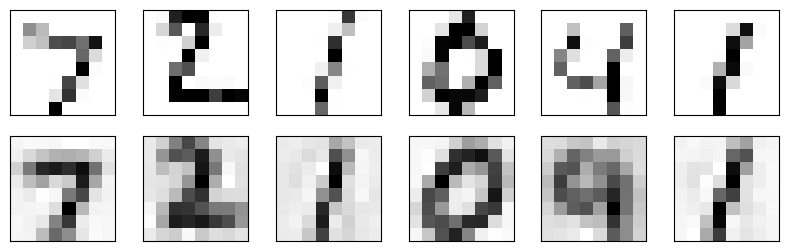

In [9]:
model_obj.plot_float_model()

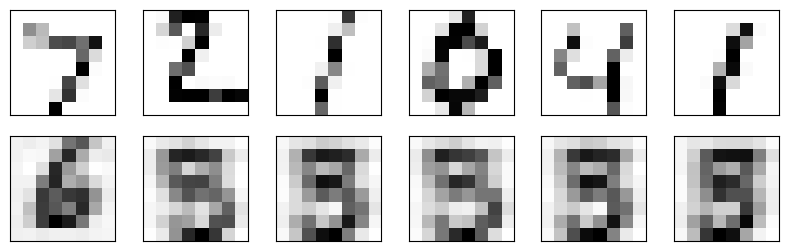

In [10]:
# obj = model_obj
# plot_quantized_model(obj, n=6)
model_obj.plot_quantized_model(n=6)

## retraining Q_model

In [15]:
# model_obj.fit_data_Q_aware(epochs=Q_EPOCHS)
# model_obj.convert_to_tflite()
# model_obj.plot_quantized_model(n=6)

## saving as pickle

In [25]:
import pickle
import tensorflow as tf

def save_objects(model_obj, MODEL_DIR):
    # Save the TensorFlow model
    model_obj.model.save(MODEL_DIR)

    # Save the TensorFlow Lite model
    with open("model_obj_tflite_model.tflite", "wb") as file:
        file.write(model_obj.quantized_tflite_model)

    # Save the other attributes of the custom object
    model_obj_dict = model_obj.__dict__.copy()
    del model_obj_dict["model"]
    del model_obj_dict["interpreter"]

    with open("model_obj_attributes.pickle", "wb") as file:
        pickle.dump(model_obj_dict, file)

def load_objects(MODEL_DIR):
    # Load the TensorFlow model
    loaded_model = tf.keras.models.load_model(MODEL_DIR)

    # Load the TensorFlow Lite model
    with open("model_obj_tflite_model.tflite", "rb") as file:
        loaded_tflite_model = file.read()

    # Load the other attributes of the custom object
    with open("model_obj_attributes.pickle", "rb") as file:
        model_obj_attributes = pickle.load(file)

    # Create a new custom object and set its attributes
    loaded_model_obj = QAutoencoder(model_obj_attributes["data_zoom"], bit_width=model_obj_attributes["BIT_WIDTH"], model_name=model_obj_attributes["MODEL_NAME"])
    for key, value in model_obj_attributes.items():
        setattr(loaded_model_obj, key, value)

    # Set the model attribute of the custom object
    loaded_model_obj.model = loaded_model
    loaded_model_obj.quantized_tflite_model = loaded_tflite_model

    # Load the interpreter
    loaded_model_obj.interpreter = tf.lite.Interpreter(model_content=loaded_tflite_model)
    loaded_model_obj.interpreter.allocate_tensors()

    return loaded_model_obj



In [26]:
import os

MODEL_DIR = os.path.abspath("model_obj_tf_model")
ASSETS_DIR = os.path.join(MODEL_DIR, "assets")

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

if not os.path.exists(ASSETS_DIR):
    os.makedirs(ASSETS_DIR)


In [28]:
# # Save the objects of model_obj
# save_objects(model_obj, MODEL_DIR)
# # # Load the objects and create a new model_obj
# # loaded_model_obj = load_objects(MODEL_DIR)

In [31]:
import h5py

def save_objects(model_obj):
    # Save the TensorFlow model
    model_obj.model.save(os.path.join(MODEL_DIR, "tf_model"))

    # Save the TensorFlow Lite model
    with open("model_obj_tflite_model.tflite", "wb") as file:
        file.write(model_obj.quantized_tflite_model)

    # Save the other attributes of the custom object
    model_obj_dict = model_obj.__dict__.copy()
    del model_obj_dict["model"]
    del model_obj_dict["interpreter"]

    # Convert the list of arrays in masked_array to a single 2D array
    masked_array = model_obj_dict["masked_array"]
    model_obj_dict["masked_array_shapes"] = [arr.shape for arr in masked_array]
    model_obj_dict["masked_array"] = np.vstack(masked_array)

    with h5py.File("model_obj_attributes.h5", "w") as file:
        for key, value in model_obj_dict.items():
            file.create_dataset(key, data=value)

def load_objects():
    # Load the TensorFlow model
    loaded_model = tf.keras.models.load_model(os.path.join(MODEL_DIR, "tf_model"))

    # Load the TensorFlow Lite model
    with open("model_obj_tflite_model.tflite", "rb") as file:
        loaded_tflite_model = file.read()

    # Load the other attributes of the custom object
    with h5py.File("model_obj_attributes.h5", "r") as file:
        model_obj_attributes = {key: file[key][()] for key in file.keys()}

    # Convert the single 2D array back to a list of arrays for masked_array
    loaded_masked_array = np.split(model_obj_attributes["masked_array"], np.cumsum(model_obj_attributes["masked_array_shapes"][:-1]))
    model_obj_attributes["masked_array"] = [arr.reshape(shape) for arr, shape in zip(loaded_masked_array, model_obj_attributes["masked_array_shapes"])]

    # Create a new custom object and set its attributes
    loaded_model_obj = QAutoencoder(model_obj_attributes["data_zoom"], bit_width=model_obj_attributes["BIT_WIDTH"], model_name=model_obj_attributes["MODEL_NAME"])
    for key, value in model_obj_attributes.items():
        setattr(loaded_model_obj, key, value)

    # Set the model attribute of the custom object
    loaded_model_obj.model = loaded_model
    loaded_model_obj.quantized_tflite_model = loaded_tflite_model

    # Load the interpreter
    loaded_model_obj.interpreter = tf.lite.Interpreter(model_content=loaded_tflite_model)
    loaded_model_obj.interpreter.allocate_tensors()

    return loaded_model_obj


In [32]:
# Save the objects of model_obj
save_objects(model_obj)

INFO:tensorflow:Assets written to: c:\Users\luisa\OneDrive\Documentos\GitHub\Autoencoder-for-FPGA\Qaware\model_obj_tf_model\tf_model\assets


INFO:tensorflow:Assets written to: c:\Users\luisa\OneDrive\Documentos\GitHub\Autoencoder-for-FPGA\Qaware\model_obj_tf_model\tf_model\assets


KeyError: 'masked_array'

In [ ]:
# Load the objects and create a new model_obj
loaded_model_obj = load_objects()

In [42]:
import pickle

def save_objects(model_obj):
    # Save the Keras model
    model_obj.model.save('model_obj_keras_model.h5')

    # Save the .tflite model
    with open("model_obj_tflite_model.tflite", "wb") as file:
        file.write(model_obj.quantized_tflite_model)

    # Save other attributes
    attrs_to_save = {
        'x_train': model_obj.x_train,
        'y_train': model_obj.y_train,
        'x_test': model_obj.x_test,
        'y_test': model_obj.y_test,
        'input_shape': model_obj.input_shape,
        'BIT_WIDTH': model_obj.BIT_WIDTH,
        'EPOCHS': model_obj.EPOCHS,
        'Q_EPOCHS': model_obj.Q_EPOCHS,
        'MODEL_NAME': model_obj.MODEL_NAME,
        'history': model_obj.history,
        'loss': model_obj.loss,
        'float_model_predictions': model_obj.float_model_predictions,
        'quantized_model_predictions': model_obj.quantized_model_predictions,
        'input_min': model_obj.input_min,
        'input_max': model_obj.input_max,
        # 'history_Q_aware': model_obj.history_Q_aware,
        # 'mse': model_obj.mse,
    }
    with open('model_obj_attributes.pickle', 'wb') as f:
        pickle.dump(attrs_to_save, f)


def load_objects():
    
    # model_obj.model.save('model_obj_keras_model.h5')
    # Load the TensorFlow model
    loaded_model = tf.keras.models.load_model(os.path.join(MODEL_DIR, "tf_model"))

    # Load the Keras model
    loaded_keras_model = tf.keras.models.load_model('model_obj_keras_model.h5')

    # Load the .tflite model
    with open("model_obj_tflite_model.tflite", "rb") as file:
        loaded_tflite_model = file.read()

    # Load other attributes
    with open('model_obj_attributes.pickle', 'rb') as f:
        loaded_attributes = pickle.load(f)
    
    # Create a new QAutoencoder object and set the attributes
    loaded_model_obj = QAutoencoder(data_zoom, bit_width=loaded_attributes['BIT_WIDTH'], model_name=loaded_attributes['MODEL_NAME'],
                                    EPOCHS=loaded_attributes['EPOCHS'], Q_EPOCHS=loaded_attributes['Q_EPOCHS'])
    
    loaded_model_obj.model = loaded_keras_model
    loaded_model_obj.quantized_tflite_model = loaded_tflite_model
    loaded_model_obj.input_min = loaded_attributes['input_min']
    loaded_model_obj.input_max = loaded_attributes['input_max']
    loaded_model_obj.input_shape = loaded_attributes['input_shape']
    loaded_model_obj.history = loaded_attributes['history']
    loaded_model_obj.history_Q_aware = loaded_attributes['history_Q_aware']
    loaded_model_obj.loss = loaded_attributes['loss']
    # loaded_model_obj.mse = loaded_attributes['mse']

    loaded_model_obj.x_train = loaded_attributes['x_train']
    loaded_model_obj.y_train = loaded_attributes['y_train']
    loaded_model_obj.x_test = loaded_attributes['x_test']
    loaded_model_obj.y_test = loaded_attributes['y_test']
    loaded_model_obj.model = loaded_model
    loaded_model_obj.history = loaded_attributes['history']
    loaded_model_obj.loss = loaded_attributes['loss']
    loaded_model_obj.float_model_predictions = loaded_attributes['float_model_predictions']
    loaded_model_obj.quantized_model_predictions = loaded_attributes['quantized_model_predictions']
    loaded_model_obj.interpreter = loaded_tflite_model
    loaded_model_obj.input_min = loaded_attributes['input_min']
    loaded_model_obj.input_max = loaded_attributes['input_max']


    # Recreate the TFLite interpreter
    loaded_model_obj.interpreter = tf.lite.Interpreter(model_content=loaded_tflite_model)
    loaded_model_obj.interpreter.allocate_tensors()
    loaded_model_obj.input_details = loaded_model_obj.interpreter.get_input_details()
    loaded_model_obj.output_details = loaded_model_obj.interpreter.get_output_details()
    # loaded_model_obj.convert_to_Q_aware()

    return loaded_model_obj


In [36]:
# Save the objects of model_obj
save_objects(model_obj)

In [43]:
# Load the objects and create a new model_obj
loaded_model_obj = load_objects()

In [47]:
loaded_model_obj.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
 dense_4 (Dense)             (None, 16)                48        
                                                                 
 dense_5 (Dense)             (None, 32)                544   

In [48]:
loaded_model_obj.quantized_tflite_model

b' \x00\x00\x00TFL3\x00\x00\x00\x00\x14\x00 \x00\x1c\x00\x18\x00\x14\x00\x10\x00\x0c\x00\x00\x00\x08\x00\x04\x00\x14\x00\x00\x00\x1c\x00\x00\x00\x94\x00\x00\x00\xc4\x00\x00\x00\x84.\x00\x00\x94.\x00\x00\x8c>\x00\x00\x03\x00\x00\x00\x01\x00\x00\x00\x10\x00\x00\x00\x00\x00\n\x00\x10\x00\x0c\x00\x08\x00\x04\x00\n\x00\x00\x00\x0c\x00\x00\x00\x1c\x00\x00\x00@\x00\x00\x00\x0f\x00\x00\x00serving_default\x00\x01\x00\x00\x00\x04\x00\x00\x00\xbc\xff\xff\xff\x18\x00\x00\x00\x04\x00\x00\x00\r\x00\x00\x00quant_dense_7\x00\x00\x00\x01\x00\x00\x00\x04\x00\x00\x00\x0e\xe2\xff\xff\x04\x00\x00\x00\x07\x00\x00\x00input_1\x00\x01\x00\x00\x00\x0c\x00\x00\x00\x08\x00\x0c\x00\x08\x00\x04\x00\x08\x00\x00\x00\x1a\x00\x00\x00\x04\x00\x00\x00\x13\x00\x00\x00min_runtime_version\x00\x1b\x00\x00\x00\xbc-\x00\x00\xb4-\x00\x00\xa4\x1d\x00\x00\x8c\x1c\x00\x00\x84\x1c\x00\x00t\x14\x00\x00\xe4\x13\x00\x00\xdc\x13\x00\x00\xcc\x11\x00\x00|\x11\x00\x00t\x11\x00\x00D\x11\x00\x00,\x11\x00\x00$\x11\x00\x00\xf4\x10\x00\x00\xa4

# Clone and fine-tune pre-trained model with quantization aware training


In [ ]:
model_obj.model

In [ ]:
# import tensorflow_model_optimization as tfmot
# model = model_obj.model
# quantize_model = tfmot.quantization.keras.quantize_model

# # q_aware stands for for quantization aware.
# q_aware_model = quantize_model(model)

# # `quantize_model` requires a recompile.
# # q_aware_model.compile(optimizer='adam',
# #               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
# #               metrics=['accuracy'])
# q_aware_model.compile(optimizer='adam', loss='mse')

# q_aware_model.summary()

### Train and evaluate the model against baseline

To demonstrate fine tuning after training the model for just an epoch, fine tune with quantization aware training on a subset of the training data.

In [ ]:
model_obj.x_train[0:1000]

In [ ]:
train_images_subset = model_obj.x_train[0:1000] # out of 60000
train_labels_subset = model_obj.x_train[0:1000]

q_aware_model.fit(train_images_subset, train_labels_subset,
                  batch_size=500, epochs=1)

In [ ]:
baseline_model_accuracy = model.evaluate(
    model_obj.x_test, model_obj.x_test, verbose=0)

q_aware_model_accuracy = q_aware_model.evaluate(
   model_obj.x_test, model_obj.x_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)

## Create quantized model for TFLite backend

After this, you have an actually quantized model with int8 weights and uint8 activations.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

q_aware_model = converter.convert()

## See persistence of accuracy from TF to TFLite

Define a helper function to evaluate the TF Lite model on the test dataset.

In [ ]:
import numpy as np

def evaluate_model(interpreter, x_test, n=6):
#   input_index = interpreter.get_input_details()[0]["index"]
#   output_index = interpreter.get_output_details()[0]["index"]
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

#   # Run predictions on every image in the "test" dataset.
#   prediction_digits = []
#   for i, test_image in enumerate(test_images):
#     if i % 1000 == 0:
#       print('Evaluated on {n} results so far.'.format(n=i))
#     # Pre-processing: add batch dimension and convert to float32 to match with
#     # the model's input data format.
#     test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
#     interpreter.set_tensor(input_index, test_image)

#     # Run inference.
#     interpreter.invoke()

#     # Post-processing: remove batch dimension and find the digit with highest
#     # probability.
#     output = interpreter.tensor(output_index)
#     digit = np.argmax(output()[0])
#     prediction_digits.append(digit)

#   print('\n')
#   # Compare prediction results with ground truth labels to calculate accuracy.
#   prediction_digits = np.array(prediction_digits)
#   accuracy = (prediction_digits == test_labels).mean()
#   return accuracy

    quantized_model_predictions = []

    for i in range(n):
        # Prepare input data
        # input_data = np.array(
        #     [x_test[i]*(2**(BIT_WIDTH-1))], dtype=np.int8)
        # input_data = np.array([(x_test[i] - input_min) / (input_max - input_min) * (2 ** (BIT_WIDTH - 1))], dtype=np.int8)  
        input_data = np.expand_dims(x_test[i], axis=0).astype(np.float32)


        interpreter.set_tensor(
            input_details[0]['index'], input_data)
        # print(f"input_data: {input_data}")
        # Run inference
        interpreter.invoke()

        # Get output
        output_data = interpreter.get_tensor(output_details[0]['index'])
        # output_data = interpreter.get_tensor(
        #     output_details[0]['index']) / (2 ** (BIT_WIDTH - 1))
        # output_data = output_data * (input_max - input_min) / (2 ** (BIT_WIDTH - 1)) + input_min
        # output_data = output_data / (2 ** (BIT_WIDTH - 1))
        # print(f"output_data: {output_data}")
        quantized_model_predictions.append(output_data)
    accuracy = (input_data == quantized_model_predictions).mean()
    
    # quantized_model_predictions = quantized_model_predictions
    return accuracy

You evaluate the quantized model and see that the accuracy from TensorFlow persists to the TFLite backend.

In [ ]:
interpreter = tf.lite.Interpreter(model_content=q_aware_model)
interpreter.allocate_tensors()

# test_accuracy = evaluate_model(interpreter, test_images=model_obj.x_test, test_labels=model_obj.x_test)
test_accuracy = evaluate_model(interpreter, model_obj.x_test, n=6)

print('Quant TF test accuracy:', q_aware_model_accuracy)
print('Quant TFLite test_accuracy:', test_accuracy)

In [ ]:
model_obj.q_aware_model.layers

In [ ]:
for layer in model_obj.q_aware_model.layers:
  if hasattr(layer, 'quantize_config'):
    for weight, quantizer, quantizer_vars in layer._weight_vars:
        quantized_and_dequantized = quantizer(weight, training=False, weights=quantizer_vars)
        min_var = quantizer_vars['min_var']
        max_var = quantizer_vars['max_var']
        print(quantized_and_dequantized*(2**(BIT_WIDTH)))
        # quantized = dequantize(quantized_and_dequantized, min_var, max_var, quantizer)

In [ ]:
model_obj.quantized_tflite_model.layers

In [ ]:
model_obj.interpreter.layers

In [ ]:
model_obj.plot_float_model()

In [ ]:
# obj = model_obj
# plot_quantized_model(obj, n=6)
model_obj.plot_quantized_model(n=6)

## See 4x smaller model from quantization

You create a float TFLite model and then see that the quantized TFLite model
is 4x smaller.

In [ ]:
import tempfile
import os

In [ ]:
# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model_obj.model)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(model_obj.quantized_tflite_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

In [ ]:
float_converter.get_tensor_details()